In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
import pdb
import matplotlib.pyplot as plt
import h5py    
import pandas as pd

import sklearn
print(sklearn.__version__)

import seaborn as sns

1.1.2


In [2]:
data_path = "/Users/marchuertascompany/Documents/data/CEERS/adversarial/"
ceers_cat = pd.read_csv(data_path+"Jeyhan_DL_match_1122_ensemble_bug.csv")
ceers_cat = ceers_cat.fillna(0)


In [3]:
filters = ['f200w','f356w','f444w']
morph=['sph','disk','irr','bd']

for f in filters:
    for m in morph:
        c = ceers_cat.filter(regex='^'+m+'_')
        c = c.filter(regex=f+'$')
        ceers_cat[m+'_'+f+'_mean']=c.mean(axis=1).values
        ceers_cat[m+'_'+f+'_std']=c.std(axis=1).values
#print(c.mean(axis=1))
#print(c.std(axis=1))
#c=ceers_cat[ceers_cat.name.str.match('sph*f200w')]
#print(c.columns)

In [4]:

morph_flag=[]
delta_value = []

for sph,dk,irr,bd in zip(ceers_cat.sph_f200w_mean,ceers_cat.disk_f200w_mean,ceers_cat.irr_f200w_mean,ceers_cat.bd_f200w_mean):
    maxpos = np.argmax([sph,dk,irr,bd])
    delta = np.sort([sph,dk,irr,bd])[3]-np.sort([sph,dk,irr,bd])[2]
    morph_flag.append(maxpos)
    delta_value.append(delta)
#morph_flag=np.array(morph_flag)
#morph_flag[(ceers_cat.disk_f200>0.3)]=1    
ceers_cat['morph_flag_f200w']=np.array(morph_flag)
ceers_cat['delta_f200']=np.array(delta_value)


In [5]:
morph_flag=[]
k=0
for spheroid,disk,irregular,ps,uncl in zip(ceers_cat.spheroid,ceers_cat.disk, ceers_cat.irregular, ceers_cat.ps, ceers_cat.unclassifiable):
    k+=1
    #print(spheroid,disk, irregular, ps, uncl)
    if (spheroid>=2 and disk<2 and irregular<2 and ps<2 and uncl<2):
        morph_flag.append(0)
        #print(k,0)
    elif (spheroid>=2 and disk>=2 and irregular<2 and ps<2 and uncl<2):
        morph_flag.append(1)
    elif (spheroid>=2 and disk>=2 and irregular>=2 and ps<2 and uncl<2):
        morph_flag.append(3)  
    elif (spheroid>=2 and disk<2 and irregular>=2 and ps<2 and uncl<2):
        morph_flag.append(2)        

    elif (spheroid<2 and disk>=2 and irregular<2 and ps<2 and uncl<2):
        morph_flag.append(4)
        #print(k,1)
    elif (spheroid<2 and disk>=2 and irregular>=2 and ps<2 and uncl<2):
        morph_flag.append(5)
        #print(k,2)
    
        #print(k,3)
    
        #print(k,5)   
    
        #print(k,6)  
    elif (spheroid<2 and disk<2 and irregular>=2 and ps<2 and uncl<2):
        morph_flag.append(6) 
        #print(k,7)    
    elif ( (ps>=2 or uncl>=2) and (spheroid<2 and disk<2 and irregular<2)):
        morph_flag.append(7) 
        #print(k,8)
    else:
        morph_flag.append(-1)    
ceers_cat['morph_flag_visual']=np.array(morph_flag)                              

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[0.63157895 0.21052632 0.0877193  0.         0.05263158 0.01754386
 0.         0.        ]
0.9298245614035088


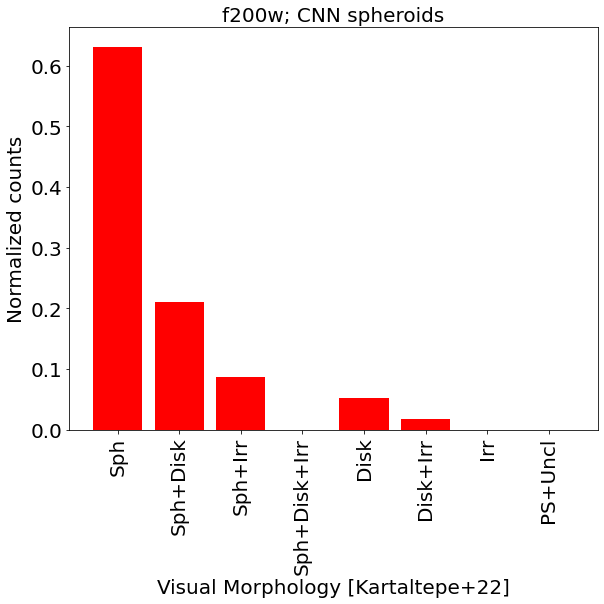

In [13]:
sel = ceers_cat.query("morph_flag_f200w==0 and morph_flag_visual>-1 and delta_f200>0.5")
all,bins = np.histogram(sel.morph_flag_visual,range=(0,8),density=True,bins=8)
bcenters = (bins[1:] + bins[:-1])/2
print(bins)
print(all)
print(np.sum(all[0:3]))
fig = plt.figure()
fig.set_size_inches(8.5, 8.5)
plt.bar(bcenters,all,tick_label=["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"],color='red')
plt.xticks(bcenters, ["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"], rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Visual Morphology [Kartaltepe+22]",fontsize=20)
plt.ylabel("Normalized counts",fontsize=20)
plt.title("f200w; CNN spheroids",fontsize=20)
plt.tight_layout()

plt.savefig(data_path+"morph_jeyhan_0.png")

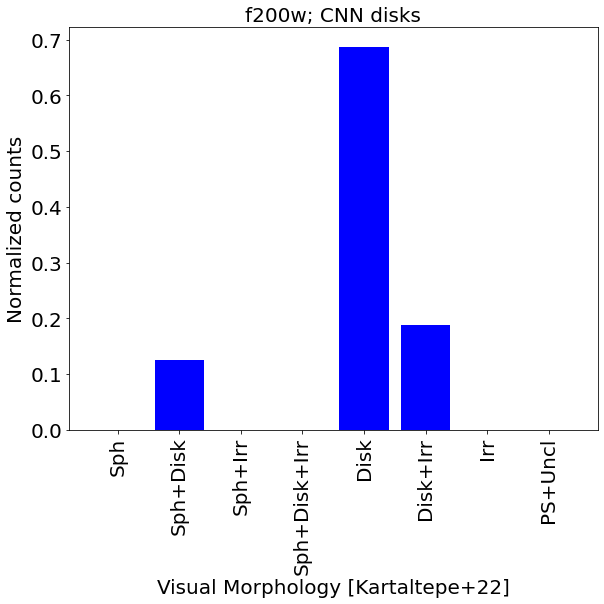

In [12]:
sel = ceers_cat.query("morph_flag_f200w==1 and morph_flag_visual>-1 and delta_f200>0.3")
all,bins = np.histogram(sel.morph_flag_visual,range=(0,8),density=True,bins=8)
bcenters = (bins[1:] + bins[:-1])/2

fig = plt.figure()
fig.set_size_inches(8.5, 8.5)
plt.bar(bcenters,all,tick_label=["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"],color='blue')
plt.xticks(bcenters, ["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"], rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Visual Morphology [Kartaltepe+22]",fontsize=20)
plt.ylabel("Normalized counts",fontsize=20)
plt.title("f200w; CNN disks",fontsize=20)
plt.tight_layout()
plt.savefig(data_path+"morph_jeyhan_1.png")

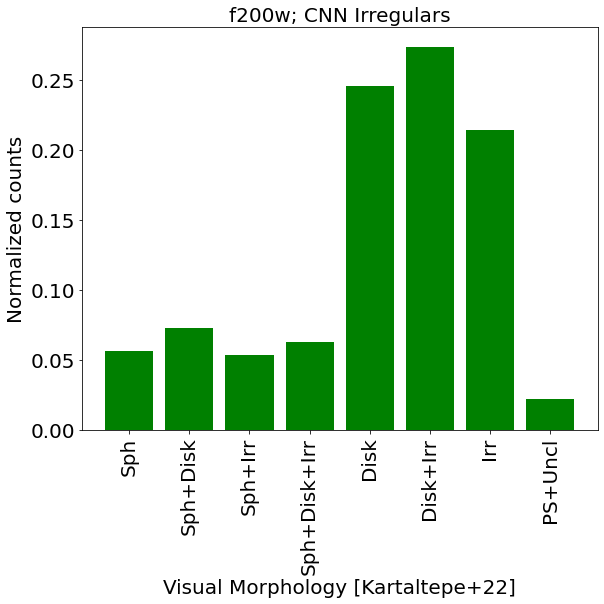

In [11]:
sel = ceers_cat.query("morph_flag_f200w==2 and morph_flag_visual>-1 and delta_f200>0.3")
all,bins = np.histogram(sel.morph_flag_visual,range=(0,8),density=True,bins=8)
bcenters = (bins[1:] + bins[:-1])/2

fig = plt.figure()
fig.set_size_inches(8.5, 8.5)
plt.bar(bcenters,all,tick_label=["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"],color='green')
plt.xticks(bcenters, ["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"], rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Visual Morphology [Kartaltepe+22]",fontsize=20)
plt.ylabel("Normalized counts",fontsize=20)
plt.title("f200w; CNN Irregulars",fontsize=20)
plt.tight_layout()
plt.savefig(data_path+"morph_jeyhan_2.png")

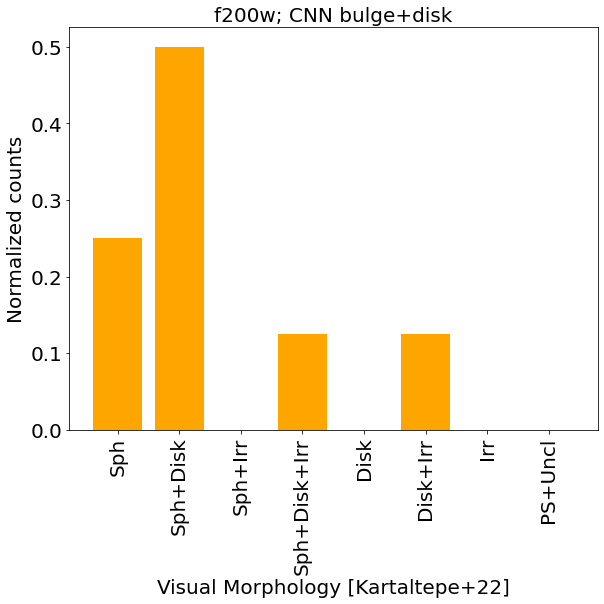

In [10]:
sel = ceers_cat.query("morph_flag_f200w==3 and morph_flag_visual>-1")
all,bins = np.histogram(sel.morph_flag_visual,range=(0,8),density=True,bins=8)
bcenters = (bins[1:] + bins[:-1])/2

fig = plt.figure()
fig.set_size_inches(8.5, 8.5)
plt.bar(bcenters,all,tick_label=["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"],color='orange')
plt.xticks(bcenters, ["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"], rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Visual Morphology [Kartaltepe+22]",fontsize=20)
plt.ylabel("Normalized counts",fontsize=20)
plt.title("f200w; CNN bulge+disk",fontsize=20)
plt.tight_layout()
plt.savefig(data_path+"morph_jeyhan_3.png")